In [1]:
%matplotlib inline


Doc2Vec Model
=============

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
import os
import gensim
from sklearn import metrics
import numpy as np
# Set file names for train and test data
train_file = os.path.join('data/all.txt')

Define a Function to Read and Preprocess Text
---------------------------------------------

Below, we define a function to:

- open the train/test file (with latin encoding)
- read the file line-by-line
- pre-process each line (tokenize text into individual words, remove punctuation, set to lowercase, etc)

The file we're reading is a **corpus**.
Each line of the file is a **document**.

.. Important::
  To train the model, we'll need to associate a tag/number with each document
  of the training corpus. In our case, the tag is simply the zero-based line
  number.




In [4]:
import smart_open

def read_corpus(fname, tokens_only=False):
    with smart_open.open(fname, encoding="iso-8859-1") as f:
        for i, line in enumerate(f):
            tokens = gensim.utils.simple_preprocess(line)
            if tokens_only:
                yield tokens
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

train_corpus = list(read_corpus(train_file))

Training the Model
------------------

Now, we'll instantiate a Doc2Vec model with a vector size with 50 dimensions and
iterating over the training corpus 40 times. We set the minimum word count to
2 in order to discard words with very few occurrences. (Without a variety of
representative examples, retaining such infrequent words can often make a
model worse!) Typical iteration counts in the published `Paragraph Vector paper <https://cs.stanford.edu/~quocle/paragraph_vector.pdf>`__
results, using 10s-of-thousands to millions of docs, are 10-20. More
iterations take more time and eventually reach a point of diminishing
returns.

However, this is a very very small dataset (300 documents) with shortish
documents (a few hundred words). Adding training passes can sometimes help
with such small datasets.




In [5]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

2019-11-17 12:59:16,125 : WARNING : consider setting layer size to a multiple of 4 for greater performance


Build a vocabulary



In [6]:
model.build_vocab(train_corpus)

2019-11-17 12:59:16,140 : INFO : collecting all words and their counts
2019-11-17 12:59:16,141 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2019-11-17 12:59:16,224 : INFO : collected 22668 word types and 37 unique tags from a corpus of 37 examples and 777116 words
2019-11-17 12:59:16,224 : INFO : Loading a fresh vocabulary
2019-11-17 12:59:16,255 : INFO : effective_min_count=2 retains 14306 unique words (63% of original 22668, drops 8362)
2019-11-17 12:59:16,255 : INFO : effective_min_count=2 leaves 768754 word corpus (98% of original 777116, drops 8362)
2019-11-17 12:59:16,283 : INFO : deleting the raw counts dictionary of 22668 items
2019-11-17 12:59:16,283 : INFO : sample=0.001 downsamples 62 most-common words
2019-11-17 12:59:16,284 : INFO : downsampling leaves estimated 581967 word corpus (75.7% of prior 768754)
2019-11-17 12:59:16,307 : INFO : estimated required memory for 14306 words and 50 dimensions: 12882800 bytes
2019-11-17 12:59:16,308 : I

Essentially, the vocabulary is a dictionary (accessible via
``model.wv.vocab``\ ) of all of the unique words extracted from the training
corpus along with the count (e.g., ``model.wv.vocab['penalty'].count`` for
counts for the word ``penalty``\ ).




Next, train the model on the corpus.
If the BLAS library is being used, this should take no more than 3 seconds.
If the BLAS library is not being used, this should take no more than 2
minutes, so use BLAS if you value your time.




In [7]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

2019-11-17 12:59:18,109 : INFO : training model with 3 workers on 14306 vocabulary and 50 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
2019-11-17 12:59:18,287 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-11-17 12:59:18,290 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-11-17 12:59:18,299 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-11-17 12:59:18,300 : INFO : EPOCH - 1 : training on 777116 raw words (370037 effective words) took 0.2s, 1961153 effective words/s
2019-11-17 12:59:18,494 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-11-17 12:59:18,499 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-11-17 12:59:18,503 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-11-17 12:59:18,503 : INFO : EPOCH - 2 : training on 777116 raw words (370037 effective words) took 0.2s, 1842915 effective words/s
2019-11-17 12:59:18,686 : INFO : 

2019-11-17 12:59:21,929 : INFO : EPOCH - 20 : training on 777116 raw words (370037 effective words) took 0.2s, 1965002 effective words/s
2019-11-17 12:59:22,100 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-11-17 12:59:22,103 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-11-17 12:59:22,111 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-11-17 12:59:22,111 : INFO : EPOCH - 21 : training on 777116 raw words (370037 effective words) took 0.2s, 2047225 effective words/s
2019-11-17 12:59:22,295 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-11-17 12:59:22,302 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-11-17 12:59:22,306 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-11-17 12:59:22,307 : INFO : EPOCH - 22 : training on 777116 raw words (370037 effective words) took 0.2s, 1909283 effective words/s
2019-11-17 12:59:22,480 : INFO : worker thr

2019-11-17 12:59:25,746 : INFO : EPOCH - 40 : training on 777116 raw words (370037 effective words) took 0.2s, 2065950 effective words/s
2019-11-17 12:59:25,746 : INFO : training on a 31084640 raw words (14801480 effective words) took 7.6s, 1938131 effective words/s


Now, we can use the trained model to infer a vector for any piece of text
by passing a list of words to the ``model.infer_vector`` function. This
vector can then be compared with other vectors via cosine similarity.




In [9]:
with open('data/HMOR/all_characters.txt') as f:
    lines = f.readlines()

In [14]:
similarity_matrix = np.zeros([45,45])
for i in range(45):
    for j in range(45):
        similarity_matrix[i,j] = metrics.pairwise.cosine_similarity(model.infer_vector(lines[i].split()).reshape(1, -1),model.infer_vector(lines[j].split()).reshape(1, -1))

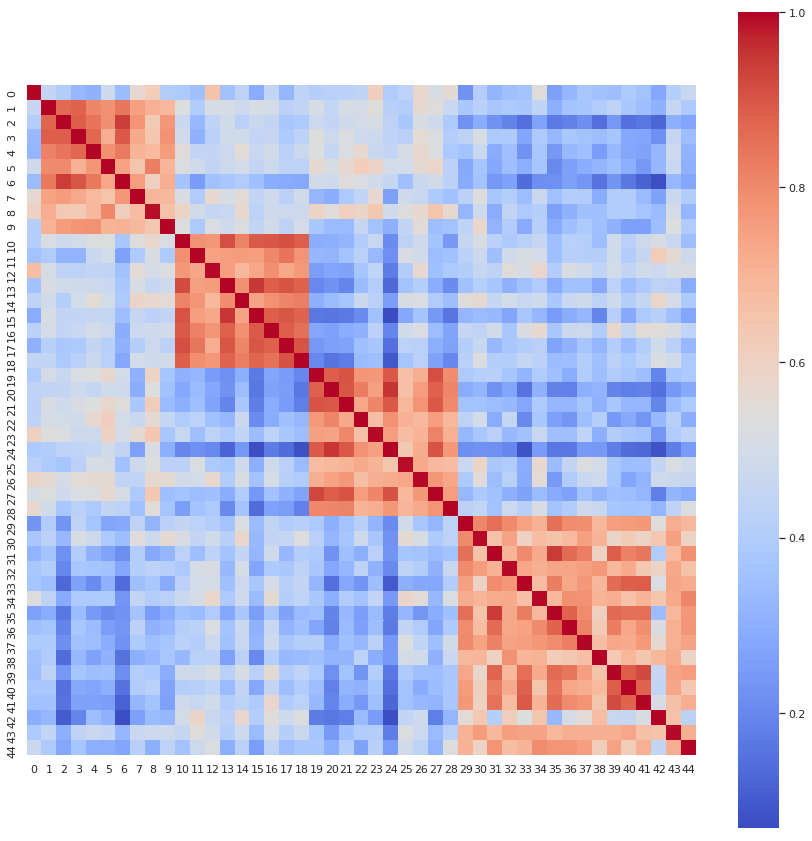

In [15]:
import seaborn as sns; sns.set()
from matplotlib import pyplot
pyplot.figure(figsize=(15, 15)) # width and height in inches
sns.heatmap(similarity_matrix, cbar = True,  square = True, annot=False,annot_kws={'size': 15},  cmap= 'coolwarm')

Conclusion
----------

Let's review what we've seen in this tutorial:

0. Review the relevant models: bag-of-words, Word2Vec, Doc2Vec
1. Load and preprocess the training and test corpora (see `core_concepts_corpus`)
2. Train a Doc2Vec `core_concepts_model` model using the training corpus
3. Demonstrate how the trained model can be used to infer a `core_concepts_vector`
4. Assess the model
5. Test the model on the test corpus

That's it! Doc2Vec is a great way to explore relationships between documents.

Additional Resources
--------------------

If you'd like to know more about the subject matter of this tutorial, check out the links below.

* `Word2Vec Paper <https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf>`_
* `Doc2Vec Paper <https://cs.stanford.edu/~quocle/paragraph_vector.pdf>`_
* `Dr. Michael D. Lee's Website <http://faculty.sites.uci.edu/mdlee>`_
* `Lee Corpus <http://faculty.sites.uci.edu/mdlee/similarity-data/>`__
* `IMDB Doc2Vec Tutorial <doc2vec-IMDB.ipynb>`_


